In [2]:
import pandas as pd
import numpy as np
import TS_general_library as tsl
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [3]:
prices = pd.read_csv("Price_data.csv", index_col=0) # Upload data
prices.index = pd.to_datetime(prices.index.astype(str), format='%Y%m%d')  # Index to DatetimeIndex
returns = prices.pct_change() # Compute returns

In [4]:
#Extract Features
features = tsl.compute_features(prices)
# Backwards fill in Nans
features = {key: value.bfill() for key, value in features.items()}

In [5]:
# Split index
split_idx = int(len(returns) * 0.9)
# Target: Next-Day Return
target_return = returns.shift(-1)
# Split target returns
train_target_return, test_target_return = target_return.iloc[:split_idx,:].bfill(), target_return.iloc[split_idx:,:].bfill().ffill()
# Split features
train_features = {key: value.iloc[:split_idx,:] for key, value in features.items()}
test_features = {key: value.iloc[split_idx:,:] for key, value in features.items()}


In [6]:
# Feature Normalisation
from sklearn.preprocessing import StandardScaler

train_scaled = {}
test_scaled = {}

# Iterate through each feature (key) in the dictionary
for feature, train_df in train_features.items():
    test_df = test_features[feature]  # Corresponding test feature DataFrame
    
    scaler = StandardScaler()

    # Fit on train data and transform train & test
    train_scaled[feature] = pd.DataFrame(scaler.fit_transform(train_df), 
                                         index=train_df.index, 
                                         columns=train_df.columns)

    test_scaled[feature] = pd.DataFrame(scaler.transform(test_df), 
                                        index=test_df.index, 
                                        columns=test_df.columns)


In [7]:
# Generate Feature map in Long format from training and testing features and target returns
train_features_map, train_target_return_map = tsl.generate_long_ftr_map(train_scaled, train_target_return)
test_features_map, test_target_return_map = tsl.generate_long_ftr_map(test_scaled, test_target_return)

In [8]:
from sklearn.preprocessing import LabelEncoder

# Reset indices
X_train_ftrs_map = train_features_map.reset_index()
y_train_targ_ret_map = train_target_return_map.reset_index()
X_test_ftrs_map = test_features_map.reset_index()
y_test_targ_ret_map = test_target_return_map.reset_index()

# Encode Asset Column
asset_encoder = LabelEncoder()
X_train_ftrs_map['Asset'] = asset_encoder.fit_transform(X_train_ftrs_map['Asset'])
X_test_ftrs_map['Asset'] = asset_encoder.transform(X_test_ftrs_map['Asset'])
y_train_targ_ret_map['Asset'] = asset_encoder.transform(y_train_targ_ret_map['Asset'])
y_test_targ_ret_map['Asset'] = asset_encoder.transform(y_test_targ_ret_map['Asset'])

# Add month to features
X_train_ftrs_map["month"] = X_train_ftrs_map["date"].dt.month  
X_test_ftrs_map["month"] = X_test_ftrs_map["date"].dt.month  

X_train_data = X_train_ftrs_map.copy()
y_train_data = y_train_targ_ret_map.copy()
X_test_data = X_test_ftrs_map.copy()
y_test_data = y_test_targ_ret_map.copy()

# Drop date and Asset from target returns
X_train = X_train_data.drop(columns=["date"]).to_numpy()
y_train = y_train_data.drop(columns=["date","Asset"]).to_numpy().flatten()  # Ensure `y_train` is 1D
X_test = X_test_data.drop(columns=["date"]).to_numpy()
y_test = y_test_data.drop(columns=["date","Asset"]).to_numpy().flatten()

In [9]:
from xgboost import XGBRegressor
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, rand

# Define objective function for Bayesian Optimisation
def objective(params):
    # print(f"Testing params: {params}") 
    model = XGBRegressor(
        objective='reg:squarederror',
        eval_metric='rmse',
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        min_child_weight=params['min_child_weight'],
        gamma=params['gamma'],
        reg_lambda= params['reg_lambda'],
        reg_alpha= params['reg_alpha'],
        n_estimators=int(params['n_estimators']),
        verbosity=0
    )
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=30, verbose=False)

    # Get RMSE for training set
    train_preds = model.predict(X_train)
    train_rmse = np.sqrt(np.mean((train_preds - y_train) ** 2))

    # Get RMSE for testing set
    test_preds = model.predict(X_test)
    test_rmse = np.sqrt(np.mean((test_preds - y_test) ** 2))

    print(f"Train RMSE: {train_rmse}, Validation RMSE: {test_rmse}")
    return {'loss': train_rmse, 'status': STATUS_OK}  # Only optimize for training loss

# Search space
space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.002), np.log(0.3)),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'subsample': hp.uniform('subsample', 0.3, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'min_child_weight': hp.loguniform('min_child_weight', np.log(0.1), np.log(20)),
    'gamma': hp.loguniform('gamma', np.log(1e-4), np.log(0.1)),
    'reg_lambda': hp.loguniform('reg_lambda', np.log(1e-4), np.log(1)),
    'reg_alpha': hp.loguniform('reg_alpha', np.log(1e-4), np.log(1)),
    'n_estimators': hp.quniform('n_estimators', 100, 2000, 100),
}

# Optimize
trials = Trials()
best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)

# Convert best_params values to correct types
best_params['max_depth'] = int(best_params['max_depth'])
best_params['n_estimators'] = int(best_params['n_estimators'])

# Print and use best_params
print("Best hyperparameters:", best_params)

# Train final model with best hyperparameters
final_model = XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    **best_params,
    verbosity=0
)

final_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=30, verbose=False)
final_model.feature_names_in_ = X_train_data.columns[1:]


Train RMSE: 0.01731423977189954, Validation RMSE: 0.017047349406239736
Train RMSE: 0.017314227764775994, Validation RMSE: 0.017048441041038694          
Train RMSE: 0.017314230059396026, Validation RMSE: 0.01704849331458292            
Train RMSE: 0.028603442588914643, Validation RMSE: 0.028771631666859813           
Train RMSE: 0.017004321934102735, Validation RMSE: 0.017072386826206848           
Train RMSE: 0.017315513263051537, Validation RMSE: 0.01705443216072664            
Train RMSE: 0.01733230220346251, Validation RMSE: 0.017085492105078336            
Train RMSE: 0.017314233721631638, Validation RMSE: 0.017047443604908587           
Train RMSE: 0.017314301007533093, Validation RMSE: 0.017049370868212343           
Train RMSE: 0.01731424028247344, Validation RMSE: 0.0170473421440219              
Train RMSE: 0.012774105212490046, Validation RMSE: 0.01782053520791033             
Train RMSE: 0.01669748813391224, Validation RMSE: 0.017111131803749333             
Train RMSE: 0.0

In [10]:
# Get feature importance
feature_importance = pd.DataFrame({
    "Feature": X_train_ftrs_map.drop(columns=["date"]).columns,
    "Importance": final_model.feature_importances_})

# Sort by importance
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)
display(feature_importance)

,Feature,Importance
11,ewma_5,0.069820
6,rv_10,0.067670
10,bb_pct,0.067095
12,ewma_20,0.066168
8,rsi_20,0.065472
5,vol_10,0.064857
13,macd,0.064167
7,vol_q_10,0.063350
14,auto_corr_5,0.062209
9,sma_ratio,0.061915


          date     Total_PnL  Positions_Chosen  Daily_Return_Pct
162 2019-11-29  1.786227e+05                 6          0.001786
163 2019-12-12 -2.996340e+03                 4         -0.000030
164 2019-12-13  9.392267e+06                 8          0.093923
165 2019-12-16  1.284179e+06                 8          0.012842
166 2019-12-17  1.097290e+05                 6          0.001097

Conditional Sharpe Ratio: 3.2221929784759373



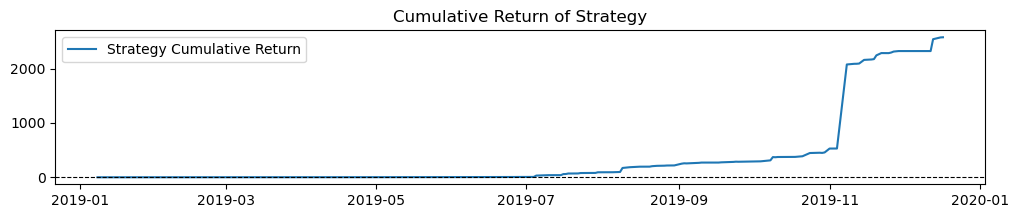

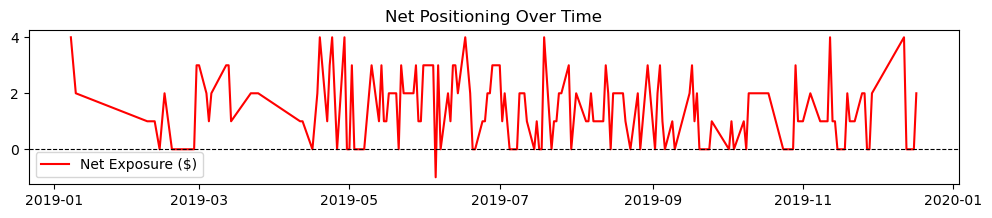

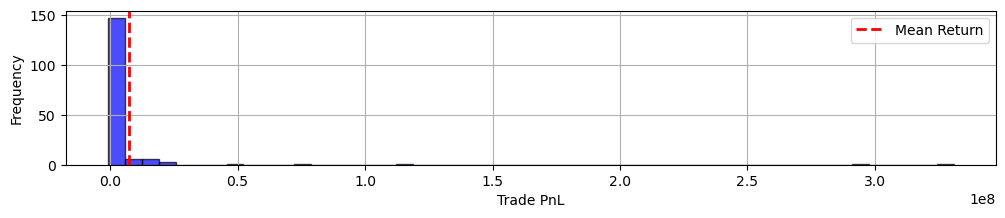

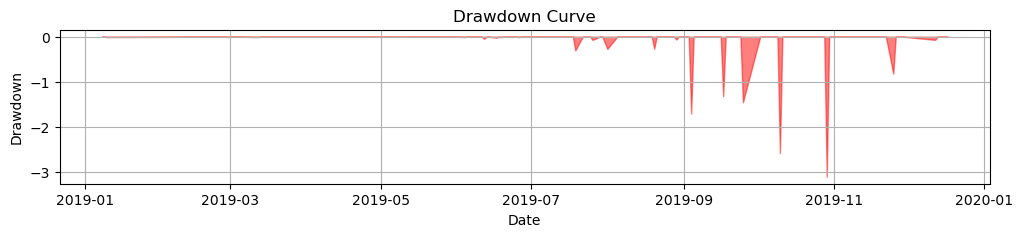

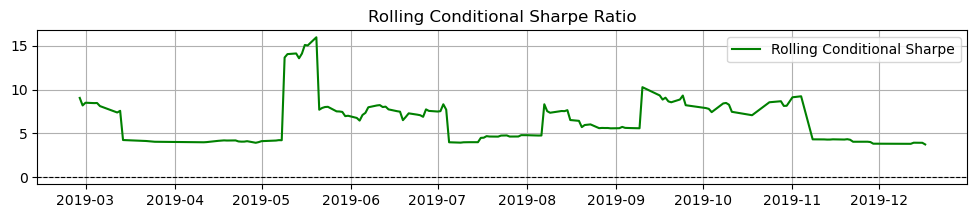

In [14]:
############## TRADING STRATEGY ############
# --- Parameters ---
MIN_PRED = 0.0005  
CAPITAL = 100_000_000  
STOP_LOSS = -0.02  # 2% Stop-Loss

def daily_strategy(df):
    """ Apply trading strategy to one day's data using improved position sizing. """
    df = df.copy()
    df['Signal'] = 0
    df['Capital_Allocation'] = 0.0  # Ensure column exists

    # Filter strong signals
    strong_mask = (df['Predicted_Return'].abs() >= MIN_PRED)
    strong_df = df[strong_mask].copy()

    if strong_df.empty:
        df['Daily_PnL'] = 0.0
        return df

    # **Dynamic Position Sizing (Ensuring Correct Long/Short Selection)**
    long_threshold = strong_df['Predicted_Return'].quantile(0.6)  
    short_threshold = strong_df['Predicted_Return'].quantile(0.4)  

    top_assets = strong_df.loc[(strong_df['Predicted_Return'] >= long_threshold) & (strong_df['Predicted_Return'] > 0), 'Asset']
    bottom_assets = strong_df.loc[(strong_df['Predicted_Return'] <= short_threshold) & (strong_df['Predicted_Return'] < 0), 'Asset']

    # Assign signals dynamically
    df['Signal'] = np.where(df['Asset'].isin(top_assets), 1, np.where(df['Asset'].isin(bottom_assets), -1, 0))

    # Volatility-based & Kelly Criterion sizing
    df['Daily_PnL'] = 0.0
    chosen_mask = (df['Signal'] != 0)
    if chosen_mask.any():
        chosen = df[chosen_mask].copy()

        # **Cap Kelly Weights to Avoid Overexposure**
        chosen['Kelly_Factor'] = chosen['Predicted_Return'] / chosen['vol_10'].clip(lower=1e-6)
        chosen['Weight'] = chosen['Kelly_Factor'] / chosen['Kelly_Factor'].sum()

        # **Cap max position size to 15% of capital**
        chosen['Weight'] = chosen['Weight'].clip(upper=0.15)

        # **Reduce Capital Allocation for Low-Confidence Trades (instead of removing them)**
        chosen['Adjusted_Weight'] = np.where(chosen['Predicted_Return'].abs() < 0.002, chosen['Weight'] * 0.5, chosen['Weight'])

        # **Ensure some capital is always allocated (5% minimum)**
        chosen['Capital_Allocation'] = CAPITAL * chosen['Adjusted_Weight']

        # **Apply Stop-Loss at -2%**
        chosen['Stop_Loss'] = -chosen['vol_10'] * chosen['Capital_Allocation']
        chosen['Daily_PnL'] = np.where(chosen['Target'] < chosen['Stop_Loss'], chosen['Stop_Loss'], 
                                       chosen['Signal'] * chosen['Capital_Allocation'] * chosen['Target'])

        # Store capital allocation in test_data
        df.loc[chosen.index, 'Capital_Allocation'] = chosen['Capital_Allocation']

        # Update original df
        df.loc[chosen.index, 'Daily_PnL'] = chosen['Daily_PnL']

    return df

def group_apply(data, group_col, func):
    """ Manual group-by for daily strategy. """
    return pd.concat([func(sub) for _, sub in data.groupby(group_col)], ignore_index=True)


# --- Data Preparation ---
test_data = X_test_data.copy()

# Predict using XGBRegressor (No DMatrix required)
test_data['Predicted_Return'] = final_model.predict(X_test)

# Merge actual target values from y_test_data
test_data = test_data.merge(y_test_data, on=['date', 'Asset'], how='left')

# Compute rolling 20-day vol using actual returns (Target)
test_data['vol_10'] = (
    test_data.groupby('Asset')['Target']
    .rolling(window=20, min_periods=10)  # Prevent NaNs in early data
    .std()
    .reset_index(level=0, drop=True)
).bfill().fillna(1e-6)

# Momentum Filter: Trade only when market is in an uptrend
market_trend = test_data.groupby('date')['Target'].mean().ewm(span=10).mean().shift(1)
trade_days = market_trend[market_trend > 0].index  # Trade only when market trend is positive
test_data = test_data[test_data['date'].isin(trade_days)]

# Apply strategy
test_data = group_apply(test_data, 'date', daily_strategy)

# Summarize daily PnL
daily_results = (
    test_data.groupby('date', as_index=False)
    .agg(
        Total_PnL=('Daily_PnL', 'sum'),
        Positions_Chosen=('Signal', lambda x: (x != 0).sum())
    )
)
daily_results['Daily_Return_Pct'] = daily_results['Total_PnL'] / CAPITAL

# Compute Cumulative Returns
cumulative_returns = (1 + daily_results['Daily_Return_Pct']).cumprod()

# Compute Position Weighted Exposure
position_weighted = test_data.pivot(index='date', columns='Asset', values='Capital_Allocation').fillna(0)

# Compute Daily Returns per Asset
daily_returns = test_data.pivot(index='date', columns='Asset', values='Target').fillna(0)

# Compute Conditional Sharpe
active_days = daily_results[daily_results['Positions_Chosen'] > 0]
avg_ret = active_days['Daily_Return_Pct'].mean()
std_ret = active_days['Daily_Return_Pct'].std(ddof=1)
conditional_sharpe = (avg_ret / std_ret) * np.sqrt(252) if std_ret != 0 else np.nan

# Compute rolling conditional Sharpe ratio for plotting
roll_win = 21
rolling_sharpe = (active_days['Daily_Return_Pct'].rolling(window=roll_win, min_periods=10).mean() / active_days['Daily_Return_Pct'].rolling(window=roll_win, min_periods=10).std(ddof=1)) * np.sqrt(252)

# Print Results
print(daily_results.tail())
print(f"\nConditional Sharpe Ratio: {conditional_sharpe}\n")

# Reindexing function
def reindex(series, new_index):
    series.index = new_index
    return series
    
# signal Dataframe
signal = test_data.pivot(index="date", columns="Asset", values="Signal")
# Plot Performance
tsl.plot_strategy_performance(reindex(cumulative_returns.copy(), signal.index), signal, pd.Series(daily_results['Total_PnL']), reindex(rolling_sharpe, signal.index))